In [1]:
## File required for this example at /uscms/home/fnavarro/nobackup/nano_darkhiggs_files/ZZTo2L2Nu.root 
import numpy as np 
from awkward import JaggedArray, Table  
import uproot, uproot_methods
import fnal_column_analysis_tools 
from fnal_column_analysis_tools.analysis_objects import JaggedCandidateArray
from histbook import *
from vega import VegaLite as canvas                
import vega
from striped.job import SinglePointStripedSession as Session, IPythonDisplay
import time

In [2]:

extractor = fnal_column_analysis_tools.lookup_tools.extractor()
extractor.add_weight_sets(['* * lookup_tables/eleTrig.root','* * lookup_tables/muon_trig_Run2016BtoF.root',
                           '* * lookup_tables/ScaleFactor_etracker_80x.json', 
                            '* * lookup_tables/EIDISO_WH_out.json','* * lookup_tables/Tight27AfterIDISO_out.json', '* * lookup_tables/failingVeto_out.json', 
                            '* * lookup_tables/ElectronID_SFs_WP90.root', '* * lookup_tables/kfactor_24bins.root'])
extractor.finalize()

evaluator = extractor.make_evaluator()


In [3]:
hist1 = Hist(bin("Dielectron_mass",50,0,200),weight='e_weight')

182987 events/sec


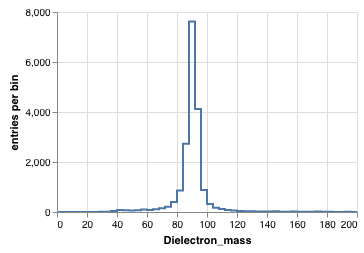

In [4]:
singleele_trigger_paths = ["HLT_Ele27_WPLoose_Gsf",
          "HLT_Ele105_CaloIdVT_GsfTrkIdT",
          "HLT_Ele27_WPTight_Gsf",
          "HLT_Ele27_eta2p1_WPTight_Gsf",
          "HLT_Ele32_eta2p1_WPTight_Gsf",
          "HLT_Ele35_WPLoose_Gsf",
          "HLT_ECALHT800"]

singleele_trigger_columns = {path:path for path in singleele_trigger_paths}
electron_columns = {'pt':'Electron_pt','eta':'Electron_eta','phi':'Electron_phi','mass':'Electron_mass','iso':'Electron_pfRelIso03_all','dxy':'Electron_dxy','dz':'Electron_dz',
                    'cutBased_HLTPreSel':'Electron_cutBased_HLTPreSel','mvaSpring16GP_WP80':'Electron_mvaSpring16GP_WP80','id':'Electron_mvaSpring16GP_WP90','charge':'Electron_charge',
                    'pdgId':'Electron_pdgId','deltaEtaSC':'Electron_deltaEtaSC'}

muon_columns = {'pt':'Muon_pt','eta':'Muon_eta','phi':'Muon_phi','mass':'Muon_mass','iso':'Muon_pfRelIso04_all','dxy':'Muon_dxy','dz':'Muon_dz','charge':'Muon_charge','tightId':'Muon_tightId',
                 'pdgId':'Muon_pdgId'}

jet_columns = {'pt':'Jet_pt','eta':'Jet_eta','phi':'Jet_phi','mass':'Jet_mass','id':'Jet_jetId'}

tau_columns = {'pt':'Tau_pt','eta':'Tau_eta','phi':'Tau_phi','mass':'Tau_mass','decayMode':'Tau_idDecayMode','decayModeNew':'Tau_idDecayModeNewDMs','id':'Tau_idMVAnew'} # (idmVAnewDM does not exist in my file) idMVAnew

photon_columns = {'pt':'Photon_pt','eta':'Photon_eta','phi':'Photon_phi','mass':'Photon_mass'}

gen_columns = {'pt':'GenPart_pt','eta':'GenPart_eta','phi':'GenPart_phi','mass':'GenPart_mass','id':'GenPart_pdgId','status':'GenPart_status', 'statusFlags':'GenPart_statusFlags','mIdx':'GenPart_genPartIdxMother'}

all_columns = [electron_columns,muon_columns,jet_columns,photon_columns,singleele_trigger_columns,tau_columns,gen_columns]

columns = []


events = 0;
for cols in all_columns: columns.extend(list(cols.values()))

   
for arrays in uproot.iterate('ZZTo2L2Nu.root','Events',columns,entrysteps=300000):
    t1 = time.time()   
        # initialize phyisics object
    triggers  = {'SingleEle':np.prod([arrays[val] for val in singleele_trigger_columns],axis=0)}
      
    electrons = JaggedCandidateArray.candidatesfromcounts(arrays[electron_columns['pt']].counts,
                **{key:arrays[val].content for key,val in electron_columns.items()})
    
    muons     = JaggedCandidateArray.candidatesfromcounts(arrays[muon_columns['pt']].counts, 
                **{key:arrays[val].content for key,val in muon_columns.items()})
    
    taus      = JaggedCandidateArray.candidatesfromcounts(arrays[tau_columns['pt']].counts, 
                **{key:arrays[val].content for key,val in tau_columns.items()})                     
    photons   = JaggedCandidateArray.candidatesfromcounts(arrays[photon_columns['pt']].counts, 
                **{key:arrays[val].content for key,val in photon_columns.items()})
    jets      = JaggedCandidateArray.candidatesfromcounts(arrays[jet_columns['pt']].counts, 
                **{key:arrays[val].content for key,val in jet_columns.items()})
    genPart   = JaggedCandidateArray.candidatesfromcounts(arrays[gen_columns['pt']].counts, 
                **{key:arrays[val].content for key,val in gen_columns.items()})
    
    events+= electrons.size
    
    # Scale Farctors to be used

    sfReco = np.ones(electrons.size)
    sfReco_up = np.ones(electrons.size)
    sfReco_down = np.ones(electrons.size)
    sfTrig = np.ones(electrons.size)
    sfTrig_up = np.ones(electrons.size)
    sfTrig_down = np.ones(electrons.size)
    sfIdIso = np.ones(electrons.size)
    sfIdIso_up = np.ones(electrons.size)
    sfIdIso_down = np.ones(electrons.size)
    sfId = np.ones(electrons.size)
    sfId_up = np.ones(electrons.size)
    sfId_down = np.ones(electrons.size)
    
    weights = np.ones(genPart.size)
    weights_up = np.ones(genPart.size)
    weights_down = np.ones(genPart.size)
    # end initialize
        # physical objects selection
    loose_electron_selection = ((electrons.pt>7)&(abs(electrons.eta)<2.4)&(abs(electrons.dxy)<0.05)&
                                (abs(electrons.dz)<0.2)&(electrons.iso<0.4))#&(electrons.id)
    loose_muon_selection =  ((muons.pt>5)&(abs(muons.eta)<2.4)&(abs(muons.dxy)<0.5)&(abs(muons.dz)<1.0)&
                             (muons.iso<0.4))
    loose_photon_selection = (photons.pt>15)&(abs(photons.eta)<2.5)
    tau_selection = (taus.pt>18)&(abs(taus.eta)<2.3)&(taus.decayMode)&((taus.id&2)!=0)
    jet_selection = (jets.pt>25)&(abs(jets.eta)<4.5)&((jets.id&2)!=0)
    
    loose_electrons = electrons[loose_electron_selection]
    loose_muons = muons[loose_muon_selection]
    loose_photons = photons[loose_photon_selection]
    selected_taus = taus[tau_selection]
    selected_jets = jets[jet_selection]
        # end seletion
    
        # lepton cleaned jets
    jet_combinations = selected_jets.p4.cross(loose_electrons.p4, nested=True)
    mask = (jet_combinations.i0.delta_r(jet_combinations.i1) < 0.3 ).any()
    e_clean_jets = selected_jets[~mask]
    
    jet_combinations = e_clean_jets.p4.cross(loose_muons.p4, nested=True)
    mask = (jet_combinations.i0.delta_r(jet_combinations.i1) < 0.3).any()
    clean_jets = e_clean_jets[~mask]
    
    # once merge is done
    # mask = selected_jets.p4.match(clean_electrons.p4, 0.3)
    # clean_jets = selected_jets[~mask]
        # end cleaning
    
    tight_electron_selection = ((loose_electrons.pt > 30)&(loose_electrons.id)&
                              (loose_electrons.mvaSpring16GP_WP80)&(loose_electrons.iso < 0.06))

    tight_electrons = loose_electrons[tight_electron_selection]
    tight_electrons_1L =tight_electrons
    
    genPart_1LSfe_selection = (abs(genPart.id==11))&(genPart.statusFlags&1 !=0)&(genPart.statusFlags&8192 != 0)
    
    gen_prompt_electrons = genPart[genPart_1LSfe_selection]
    gen_electrons_combinations = tight_electrons.p4.cross(gen_prompt_electrons.p4,nested=True)
    gen_electrons_mask = (gen_electrons_combinations.i0.delta_r(gen_electrons_combinations.i1)<0.4).any()

    _1L_electrons = tight_electrons[gen_electrons_mask]
   
    # 1L channel weights
    sfReco_value ='ScaleFactor_tracker_80x/eta_pt_ratio_value'
    sfReco_error = 'ScaleFactor_tracker_80x/eta_pt_ratio_error'
    sfIdIso_value = 'EIDISO_WH/eta_pt_ratio_value'
    sfIdIso_error = 'EIDISO_WH/eta_pt_ratio_error'
    sfTrig_value = 'Tight27AfterIDISO/eta_pt_ratio_value'
    sfTrig_error = 'Tight27AfterIDISO/eta_pt_ratio_error'
    
    c =_1L_electrons.counts
    etaSC = _1L_electrons.eta+_1L_electrons.deltaEtaSC
    pt = _1L_electrons.pt
    sfReco[c>0] = evaluator[sfReco_value](etaSC,pt)[c>0][:,0]
    sfReco_up[c>0] = sfReco[c>0] + evaluator[sfReco_error](etaSC,pt)[c>0][:,0]
    sfReco_down[c>0] = sfReco[c>0] - evaluator[sfReco_error](etaSC,pt)[c>0][:,0]
    sfReco_up[c>0][_1L_electrons[c>0].pt[:,0] >80] = sfReco_up[c>0][_1L_electrons[c>0].pt[:,0] >80] + 0.01
    sfReco_down[c>0][_1L_electrons[c>0].pt[:,0] >80] = sfReco_down[c>0][_1L_electrons[c>0].pt[:,0] >80] - 0.01

    sfIdIso[c >0] = evaluator[sfIdIso_value](etaSC,pt)[c>0][:,0]
    sfIdIso_up[c>0] = sfIdIso[c > 0] + evaluator[sfIdIso_error](etaSC,pt)[c>0][:,0]
    sfIdIso_down[c>0] =sfIdIso[c > 0] - evaluator[sfIdIso_error](etaSC,pt)[c>0][:,0]

    sfTrig[c>0] = evaluator[sfTrig_value](etaSC,pt)[c>0][:,0]
    sfTrig_up[c>0] = sfTrig[c>0] + evaluator[sfTrig_error](etaSC, pt)[c>0][:,0]
    sfTrig_down[c>0] =sfTrig[c>0] - evaluator[sfTrig_error](etaSC,pt)[c>0][:,0]
        
    weight = sfReco*sfTrig*sfIdIso*sfId
    weight_up = sfReco_up*sfTrig_up*sfIdIso_up*sfId
    weight_down = sfReco_down*sfTrig_down*sfIdIso_down*sfId
    
    
    dielectron_selection = (tight_electrons.counts>0)&(clean_jets.counts==0)#&(triggers["SingleEle"]==1)#&(loose_photons.counts==0)
    
    dielectrons = loose_electrons[dielectron_selection].distincts()
    dielectron_mass = dielectrons.mass
    e_weight = weight[dielectron_selection][dielectrons.counts>0]
    dielectron_mass = dielectron_mass[dielectron_mass.counts>0][:,0]
        # end dileptons
    
        # plots
    hist1.fill(Dielectron_mass=dielectron_mass,e_weight=e_weight)
t2 = time.time()    
print str(int(events/(t2-t1)))+" events/sec"
disp = beside(hist1.step("Dielectron_mass",width=300))
display = IPythonDisplay(disp)
display.init()
disp.to(canvas)

In [5]:
t =triggers['SingleEle']
t[triggers['SingleEle']==1].size

37